# WSA Scikit-Learn Classification Demo

## Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn import svm, neighbors, ensemble, metrics
from sklearn.model_selection import cross_val_score, LeaveOneOut

In [2]:
df = pd.read_csv('Michigan_GameLogs_F24.csv').drop(columns=['id'])
df.rename(columns = {
    'home_away' : 'location',
    'points_scored' : 'pts_scored',
    'points_against' : 'pts_against',
    'pass_td' : 'pass_tds',
    'pass_1st_down' : 'pass_first_downs',
    'rush_td' : 'rush_tds',
    'rush_1st_down' : 'rush_first_downs'
}, inplace = True)
df.tail()

,date,year,opponent,location,result,pts_scored,pts_against,pass_cmp,pass_att,pass_pct,pass_yrds,pass_tds,pass_first_downs,rush_att,rush_yrds,rush_tds,rush_first_downs,total_offense,fumbles,ints
170,2024-10-05,2024,Washington,Away,L,17,27,13,25,52.0,113,1,7,37,174,1,9,287,1,1
171,2024-10-19,2024,Illinois,Away,L,7,21,20,32,62.5,208,0,8,38,114,1,10,322,2,1
172,2024-10-26,2024,Michigan State,Home,W,24,17,14,20,70.0,146,2,9,31,119,1,7,265,0,0
173,2024-11-02,2024,Oregon,Home,L,17,38,13,25,52.0,165,2,7,28,105,0,4,270,0,0
174,2024-11-09,2024,Indiana,Away,L,15,20,16,32,50.0,137,0,7,34,69,1,6,206,1,0


## Classification Introduction

Recall that supervised learning involves modeling the relationship between measured features of a dataset $X$ and a label $y$ associated with that data. Using that model, we can predict the labels for new data of the same structure. Regression tasks deal with continuous labels, while classification tasks are used for labels that are **discrete**.

The general procedure for using classification algorithms in *scikit-learn* is the same for both types of tasks. We split our datasets into training and test splits using `train_test_split()`, `.fit()` our model to the training dataset, and predict the labels using `.predict()`.

For this exercise, we will seek to predict the game result using features such as game location, passing and rushing yards, touchdowns, and turnovers,  using the game result (**W** or **L**) as our label. This is an example of **binary classification**, since we only have two possible class labels.

### Cross-Validation

To prevent overfitting, we will evaluate our model performance using cross-validation. By splitting our dataset into multiple subsets, we can use each subset as a separate validation set (and the rest as the training set), then aggregate the results across all "folds" of the cross-validation process. 

For larger datasets, it is suitable to split your dataset into sizable training and testing sets, then use cross-validation among your training set. Validation is solely for assessing model performance and hyperparameter tuning, whereas the test set is completely unused throughout the training process, and it is used only to evaluate the final model.

Because we have a small dataset (~170 points), we can easily employ *leave-one-out* cross-validation. We will run a set of trials where we train on all points in the dataset except for one, then use that point as our validation set, and repeat so that each point in the dataset is used as the validation set. Our cross-validation score will be the average across trials.

We will be using the games from 2011-2023 for training and validation, then test our final model on the games from 2024.

### Data Preprocessing

First, we use `.map()` to encode game result and location as numerical values.

In [5]:
df['win'] = df['result'].map({'W': 1, 'L': 0})
df['win']

0      1
1      1
2      1
3      1
4      1
      ..
170    0
171    0
172    1
173    0
174    0
Name: win, Length: 175, dtype: int64

In [7]:
# Away and Neutral grouped together
df['home'] = df['location'].map({'Home': 1, 'Away': 0, 'Neutral': 0})
df['home']

0      1
1      1
2      1
3      1
4      1
      ..
170    0
171    0
172    1
173    1
174    0
Name: home, Length: 175, dtype: int64

In [9]:
# Separating 2024 games
df_2024 = df[df['year'] == 2024].copy()
df_rest = df[df['year'] != 2024].copy()

df_2024

,date,year,opponent,location,result,pts_scored,pts_against,pass_cmp,pass_att,pass_pct,...,pass_first_downs,rush_att,rush_yrds,rush_tds,rush_first_downs,total_offense,fumbles,ints,win,home
165,2024-08-31,2024,Fresno State,Home,W,30,10,16,27,59.3,...,9,34,148,0,8,269,0,1,1,1
166,2024-09-07,2024,Texas,Home,L,12,31,22,33,66.7,...,9,23,80,0,4,284,1,2,0,1
167,2024-09-14,2024,Arkansas State,Home,W,28,18,13,18,72.2,...,6,44,301,3,14,435,0,3,1,1
168,2024-09-21,2024,Southern California,Home,W,27,24,7,12,58.3,...,0,46,290,3,12,322,2,0,1,1
169,2024-09-28,2024,Minnesota,Home,W,27,24,10,18,55.6,...,5,43,155,2,9,241,0,1,1,1
170,2024-10-05,2024,Washington,Away,L,17,27,13,25,52.0,...,7,37,174,1,9,287,1,1,0,0
171,2024-10-19,2024,Illinois,Away,L,7,21,20,32,62.5,...,8,38,114,1,10,322,2,1,0,0
172,2024-10-26,2024,Michigan State,Home,W,24,17,14,20,70.0,...,9,31,119,1,7,265,0,0,1,1
173,2024-11-02,2024,Oregon,Home,L,17,38,13,25,52.0,...,7,28,105,0,4,270,0,0,0,1
174,2024-11-09,2024,Indiana,Away,L,15,20,16,32,50.0,...,7,34,69,1,6,206,1,0,0,0


In [11]:
# Extract features to be used
X_train = df_rest[['home', 'pass_cmp', 'pass_att', 'pass_pct', 'pass_yrds', 'pass_tds', 'pass_first_downs', 'rush_att', 'rush_yrds', 'rush_tds', 'rush_first_downs', 'fumbles', 'ints']]
y_train = df_rest['win']

X_test = df_2024[['home', 'pass_cmp', 'pass_att', 'pass_pct', 'pass_yrds', 'pass_tds', 'pass_first_downs', 'rush_att', 'rush_yrds', 'rush_tds', 'rush_first_downs', 'fumbles', 'ints']]
y_test = df_2024['win']

## Classification Methods

Some common classification algorithms include:
* Support Vector Machines
* K-Nearest Neighbors
* Random Forests


### Method 1: Support Vector Machines

We can use support vector machines to find the optimal decision boundary in an N-dimensional feature space that separates data points into different classes by label. This boundary is "hard" if it cleanly separates all datapoints (implausible in practice), and "soft" otherwise. Scikit-learn provides an implementation of Support Vector Machines in the [`svm`](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html#sklearn.svm.SVC) module.

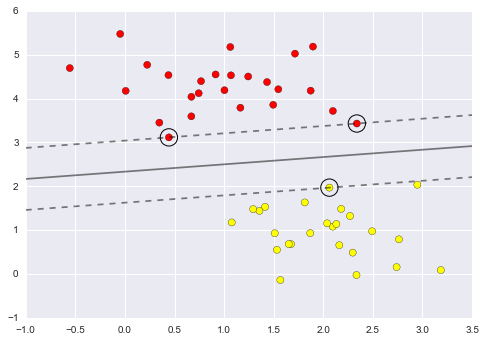


With SVMs, we can adjust the kernel as part of the model selection process, along with the softness of the boundary margin, which is set by the `C` parameter. Lower values of C have a greater tolerance for misclassifcations, but this can lead to underfitting by a biased model.

By using a non-linear kernel, we can transform and linearly separate our original data in a higher-dimensional space if necessary. Options include a linear kernel, polynomial kernel, and RBF (Gaussian) kernel, which is the default.

* Linear: $K(w,b) = w^Tx+b$
* Polynomial: $K(w,x) = (\gamma w^Tx+b)^N$
* Gaussian / RBF: $K(w,x) = \text{exp}(-\gamma ||x_i-x_j||)^n$

In [13]:
cubic_svm = svm.SVC(kernel='poly', degree=3)  # degree is 3.0 by default for polynomial kernel
cubic_svm.fit(X_train, y_train)

scores = cross_val_score(cubic_svm, X_train, y_train, cv=LeaveOneOut())
scores.mean()

0.8303030303030303

In [15]:
quadratic_svm = svm.SVC(kernel='poly', degree=2)
quadratic_svm.fit(X_train, y_train)

scores = cross_val_score(quadratic_svm, X_train, y_train, cv=LeaveOneOut())
scores.mean()

0.8484848484848485

In [16]:
gaussian_svm = svm.SVC(kernel='rbf', C=1.0)  # C is 1.0 by default
gaussian_svm.fit(X_train, y_train)

scores = cross_val_score(gaussian_svm, X_train, y_train, cv=LeaveOneOut())
scores.mean()

0.8606060606060606

### Method 2: K-Nearest Neighbors

The K-Nearest Neighbors algorithm works by finding the K nearest neighbors to a given data point based on a certain distance metric. The label of the target data point is then determined by the most frequent label among the point's K neighbors. Because data tends to be sparser is higher dimensions, it works best with datasets that have a limited number of features. Scikit-learn provides an implementation of K-Nearest Neighbors for classification in the `neighbors` module.

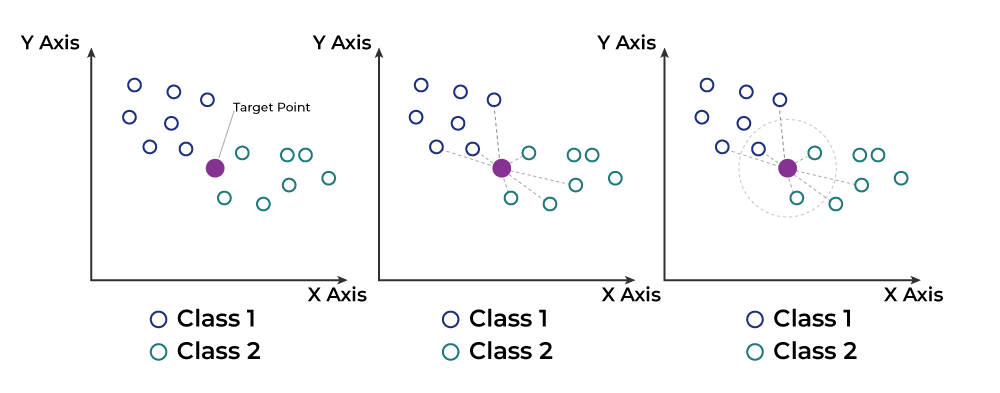

With this method, we can adjust both the distance metric and the number of neighbors, and use cross-validation to select the optimal model. In this example, we will focus on selecting K, and all classifiers will use the default 'minkowski' distance. Other valid distance metrics can be found [here](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise.distance_metrics.html#sklearn.metrics.pairwise.distance_metrics).

In [19]:
# Investigating K for values of 1,3,5,7,9,11
for i in np.arange(1,12,2):
    clf = neighbors.KNeighborsClassifier(n_neighbors=i)
    clf.fit(X_train, y_train)
    scores = cross_val_score(clf, X_train, y_train, cv=LeaveOneOut())
    print(f'average CV score is {scores.mean():.4f} for K = {i}')

average CV score is 0.7697 for K = 1
average CV score is 0.8545 for K = 3
average CV score is 0.8667 for K = 5
average CV score is 0.8667 for K = 7
average CV score is 0.8667 for K = 9
average CV score is 0.8485 for K = 11


### Method 3: Random Forest

The random forest is an example of a robust *ensemble method*, which aggregates the results of a group of simpler estimators. For a random forest, each classifier is a "decision tree", which splits data into subsets based quantitative criteria (one at each layer). Labels for new data can then be assigned just by going down the tree until the final layer containing a label is reached. A decision tree is extremely easy to interpret, but is ineffective by itself for classification, as it will overfit our data if we have a unique path for each point.   

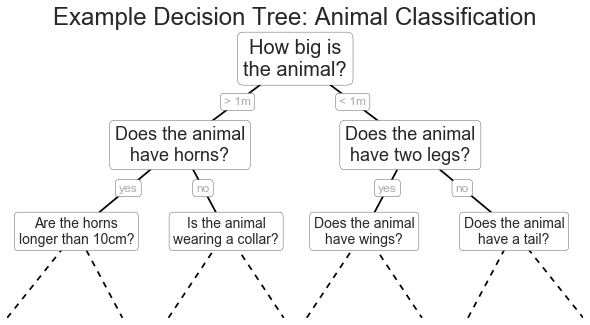

With a random forest, we fit multiple decision trees, each to a random subset of our data (and, if we choose, a subset of features). We then average the results, where the assigned label for a new data point is determined by majority vote among the decision trees. Scikit-learn provides a Random Forest implementation in the [`ensemble`](https://scikit-learn.org/stable/api/sklearn.ensemble.html#module-sklearn.ensemble) module, where we can specify the number of trees in our forest and the structure of each tree.

Some hyperparameters we can adjust are:
* Maximum depth of the tree ('max_depth')
* Minimum number of samples required to split an internal node ('min_samples_split')
    * Defaults to 2
* Maximum number of features to consider when looking for the best split ('max_features')
    * Defaults to square root of number of features 
* Maximum number of leaf nodes a tree can have at lowest level ('max_leaf_nodes')

In [21]:
rfc = ensemble.RandomForestClassifier(n_estimators=200)  # default is 100
rfc.fit(X_train, y_train)
scores = cross_val_score(rfc, X_train, y_train, cv=5)  # 5-fold cv for speed
scores.mean()

0.8606060606060607

In [23]:
# Which features were the most important for classification using the (default) Random Forest?

feature_importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': rfc.feature_importances_
}).sort_values(by='Importance', ascending=False)

print(feature_importance_df.to_string(index=False))

         Feature  Importance
       rush_yrds    0.254013
        pass_att    0.121020
        pass_pct    0.103957
        rush_tds    0.086020
        rush_att    0.080439
rush_first_downs    0.073816
            ints    0.065898
       pass_yrds    0.051812
        pass_cmp    0.050617
        pass_tds    0.039871
pass_first_downs    0.034123
         fumbles    0.019767
            home    0.018649


## Model Evaluation and Metrics

In [25]:
# Proceeding with the gaussian_svm, which had one of the highest CV scores overall
y_model = gaussian_svm.predict(X_test)

Below, we plot a **confusion matrix** to more clearly identify our selected model's performance on our test data. For binary classification, we have a 2x2 confusion matrix.

* True Positives:
    * Correctly predict positive label (1) for actual positive result (1)
    * Upper-left quadrant
* False Negatives:
    * Incorrectly predict negative label (0) for actual positive result (1)
    * Upper-right quadrant
* False Positives:
    * Incorrectly predict positive label (1) for actual negative result (0)
    * Lower-left quadrant
* True Negatives:
    * Correctly predict negative label (0) for actual negative result (0)
    * Lower-right quadrant

Text(0, 0.5, 'true value')

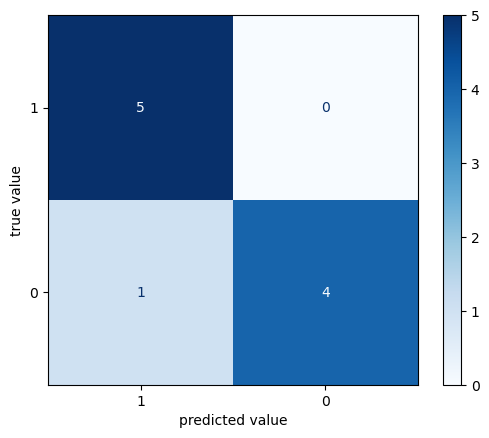

In [27]:
cm = metrics.confusion_matrix(y_test, y_model)
disp = metrics.ConfusionMatrixDisplay(cm)
disp.plot(cmap=plt.cm.Blues)
plt.gca().invert_xaxis()
plt.gca().invert_yaxis()
plt.xlabel('predicted value')
plt.ylabel('true value')

For our SVM with the RBF kernel, we had a single false positive. All other labels were predicted correctly. Comparing our predicted and true labels, we identify the false positive as the game against Washington in the 2024 regular season.

In [29]:
differing_indices = y_test[y_test != y_model].index
df.iloc[differing_indices[0]]

date                2024-10-05
year                      2024
opponent            Washington
location                  Away
result                       L
pts_scored                  17
pts_against                 27
pass_cmp                    13
pass_att                    25
pass_pct                  52.0
pass_yrds                  113
pass_tds                     1
pass_first_downs             7
rush_att                    37
rush_yrds                  174
rush_tds                     1
rush_first_downs             9
total_offense              287
fumbles                      1
ints                         1
win                          0
home                         0
Name: 170, dtype: object

Common metrics we can use to summarize the confusion matrix data include the following. Most are available as functions within the `sklearn.metrics` [module](https://scikit-learn.org/stable/api/sklearn.metrics.html). 
* **Accuracy**: $\frac{TP+TN}{TP+FP+TN+FN}$
   * Fraction of true predictions
* **Precision**:$\frac{TP}{TP+FP}$
    * Measures correctness of positive predictions
    * Use when we want to minimize false positives
* **Recall**: $\frac{TP}{TP+FN}$
    * Measures completeness of positive predictions
    * Use when we want to minimize false negatives
* **F1-Score**: $\frac{2*\text{Precision}*\text{Recall}}{\text{Precision}+\text{Recall}}$
    * Balance between precision and recall
    * Calculates the harmonic mean of those two metrics
* **Specificity**: $\frac{TN}{TN+FP}$
    * Measures correctness of negative predictions

In [31]:
# Example for F1-Score
mod_f1_score = metrics.f1_score(y_true=y_test, y_pred=y_model)
mod_f1_score

0.9090909090909091

In [33]:
# Example to calculate specificity
TP = cm[1,1]
FP = cm[0,1]
TN = cm[0,0]
FN = cm[1,0]

specificity = TN/(TN+FP)  # 4/5
specificity

0.8